In [1]:
!pip install skfolio

In [2]:
#!pip install --upgrade pip


In [3]:
#conda install -c conda-forge yfinance


In [4]:
!pip install pandas_datareader

In [5]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignoring the warnings while executing codes
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

from datetime import datetime
from tabulate import tabulate
from plotly.io import show
from sklearn.model_selection import train_test_split

from skfolio import PerfMeasure, RatioMeasure, RiskMeasure
from skfolio.optimization import MeanRisk
from skfolio.preprocessing import prices_to_returns
# Color pallet and theme
import matplotlib.colors

# Define custom colors
"#283149"  # Dark blue
"#404B69"  # Medium blue
"#DBEDF3"  # Light blue
"#DBDBDB"  # Gray
"#FFFFFF"  # White

colors = ["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"]
colors2 = ["#FFFFFF", "#DBDBDB", "#DBEDF3", "#404B69", "#283149"]
colors3 = ['#404B69', '#5CDB95', '#ED4C67', '#F7DC6F']

my_palette = sns.color_palette(["#283149", "#404B69", "#DBEDF3", "#DBDBDB", "#FFFFFF"])

cmap = matplotlib.colors.ListedColormap(colors)
cmap2 = matplotlib.colors.ListedColormap(colors2)

In [6]:
# Define the list of stock symbols
selected_tickers = [
    'TSLA', 'BND', 'SPY'
]

# Define the start date as '2020-01-01'
start_date = '2015-01-01'

# Get the current date as the end date
end_date = '2024-10-31'

# Retrieve data from Yahoo Finance for each stock symbol
stock_data = {}
for symbol in selected_tickers:
    try:
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)
        print(f"Data successfully retrieved for {symbol}.")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Print the first few rows of the data for each stock
for symbol, data in stock_data.items():
    print(f"Stock Symbol: {symbol}")
    print(data.tail(2))
    print()


[*********************100%***********************]  1 of 1 completed


Data successfully retrieved for TSLA.


[*********************100%***********************]  1 of 1 completed


Data successfully retrieved for BND.


[*********************100%***********************]  1 of 1 completed

Data successfully retrieved for SPY.
Stock Symbol: TSLA
Price                       Adj Close       Close        High         Low  \
Ticker                           TSLA        TSLA        TSLA        TSLA   
Date                                                                        
2024-10-29 00:00:00+00:00  259.519989  259.519989  264.980011  255.509995   
2024-10-30 00:00:00+00:00  257.549988  257.549988  263.350006  255.820007   

Price                            Open    Volume  
Ticker                           TSLA      TSLA  
Date                                             
2024-10-29 00:00:00+00:00  264.510010  80521800  
2024-10-30 00:00:00+00:00  258.040009  53993600  

Stock Symbol: BND
Price                      Adj Close      Close       High        Low  \
Ticker                           BND        BND        BND        BND   
Date                                                                    
2024-10-29 00:00:00+00:00  72.901749  73.129997  73.139999  72.790001 

### Close price of equities

In [7]:
# Concatenate 'Close' prices from each DataFrame into a single DataFrame
close_prices = pd.concat([data['Adj Close'] for data in stock_data.values()], axis=1)
close_prices.columns = selected_tickers  # Set column names as selected tickers

# Print the first few rows of the new DataFrame
print("Close Prices:")
print(close_prices.head())


Close Prices:
                                TSLA        BND         SPY
Date                                                       
2015-01-02 00:00:00+00:00  14.620667  63.358768  173.173752
2015-01-05 00:00:00+00:00  14.006000  63.542786  170.046280
2015-01-06 00:00:00+00:00  14.085333  63.726730  168.444672
2015-01-07 00:00:00+00:00  14.063333  63.765076  170.543686
2015-01-08 00:00:00+00:00  14.041333  63.665394  173.569946


In [8]:
# Calculate missing values for each column
close_prices.isna().sum().to_frame().T


,TSLA,BND,SPY
0,0,0,0


In [9]:
close_prices.describe().T

,count,mean,std,min,25%,50%,75%,max
TSLA,2474.0,111.438965,110.120450,9.578000,17.066167,25.043000,216.865002,409.970001
BND,2474.0,70.089251,4.889919,62.637539,66.314075,68.888943,73.807495,79.812935
SPY,2474.0,310.253153,111.250657,157.328598,214.822361,275.812286,402.297485,584.590027


In [10]:
# Extract descriptive summary of 'Close' prices for each stock
summary_data = []
for symbol, data in stock_data.items():
    summary = [symbol] + list(data['Adj Close'].describe().values)
    summary_data.append(summary)

# Display the summary using tabulate
headers = ['Stock Symbol', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
print(tabulate(summary_data, headers=headers))

Stock Symbol      count      mean        std       min       25%       50%       75%       max
--------------  -------  --------  ---------  --------  --------  --------  --------  --------
TSLA               2474  111.439   110.12       9.578    17.0662   25.043   216.865   409.97
BND                2474   70.0893    4.88992   62.6375   66.3141   68.8889   73.8075   79.8129
SPY                2474  310.253   111.251    157.329   214.822   275.812   402.297   584.59


In [11]:
# Calculate log returns for each symbol
log_returns = np.log(1 + close_prices.pct_change())

# Print the first few rows of log returns for each symbol
print("Log Returns for Each Symbol:")
print(log_returns.head())

Log Returns for Each Symbol:
                               TSLA       BND       SPY
Date                                                   
2015-01-02 00:00:00+00:00       NaN       NaN       NaN
2015-01-05 00:00:00+00:00 -0.042950  0.002900 -0.018225
2015-01-06 00:00:00+00:00  0.005648  0.002891 -0.009463
2015-01-07 00:00:00+00:00 -0.001563  0.000602  0.012384
2015-01-08 00:00:00+00:00 -0.001566 -0.001564  0.017589


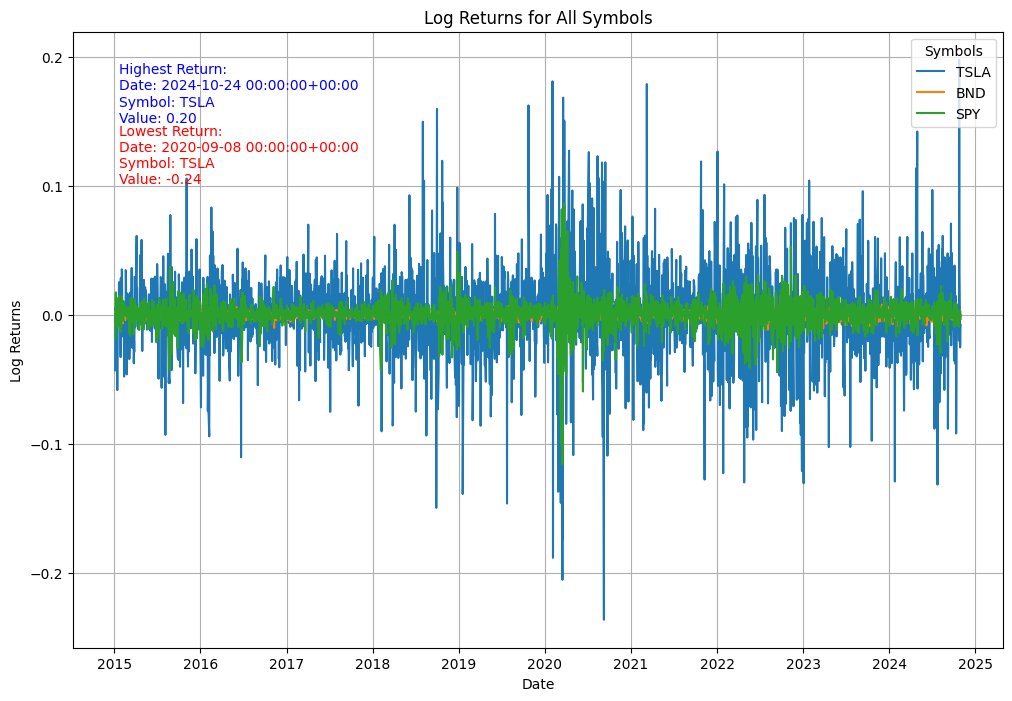

In [12]:
import matplotlib.pyplot as plt

# Set up the single figure
plt.figure(figsize=(12, 8))

# Iterate over each symbol to add it to the same plot as a line
for symbol in log_returns.columns:
    # Plot the log returns for the current symbol as a line
    plt.plot(log_returns.index, log_returns[symbol], label=symbol)

# Add title, labels, and legend
plt.title('Log Returns for All Symbols')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True)
plt.legend(title='Symbols', loc='upper right')

# Find the overall highest and lowest points across all symbols
overall_highest_point = log_returns.max().max()
overall_lowest_point = log_returns.min().min()

# Get the indices of these points
idx_highest = log_returns.stack().idxmax()
idx_lowest = log_returns.stack().idxmin()

# Add text indicating the highest and lowest returns
plt.text(0.05, 0.95, f'Highest Return:\nDate: {idx_highest[0]}\nSymbol: {idx_highest[1]}\nValue: {overall_highest_point:.2f}', 
         transform=plt.gca().transAxes, color='blue', ha='left', va='top')
plt.text(0.05, 0.85, f'Lowest Return:\nDate: {idx_lowest[0]}\nSymbol: {idx_lowest[1]}\nValue: {overall_lowest_point:.2f}', 
         transform=plt.gca().transAxes, color='red', ha='left', va='top')

# Show the plot
plt.show()


In [13]:
# Calculate variance for each stock symbol
var = log_returns.var()

# Print the variance for each symbol
print("Variance for Each Symbol:")
print(var)

Variance for Each Symbol:
TSLA    0.001276
BND     0.000012
SPY     0.000125
dtype: float64


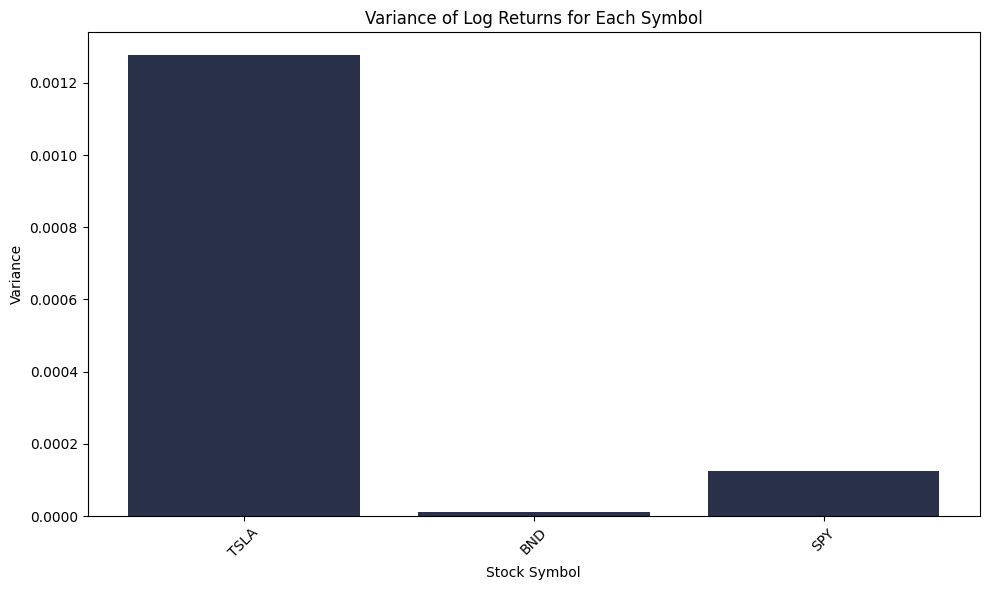

In [14]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(var.index, var.values, color='#283149')  # Assuming you want to use the first color in your defined palette
plt.title('Variance of Log Returns for Each Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Variance')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

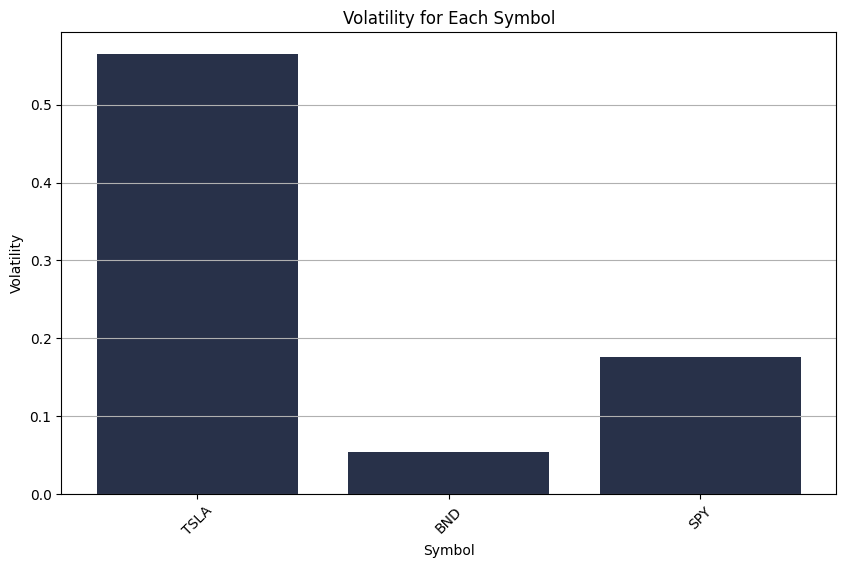

In [15]:
# Calculate volatility using the provided formula (square root of variance * sqrt(250))
volatility_values = np.sqrt(var * 250)

# Plot bar chart for volatility
plt.figure(figsize=(10, 6))
plt.bar(volatility_values.index, volatility_values.values, color='#283149')
plt.title('Volatility for Each Symbol')
plt.xlabel('Symbol')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [16]:
# Calculate covariance between all symbols
covariance_matrix = log_returns.cov()

print("Covariance Matrix:")
print(covariance_matrix)


Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.001276  0.000007  0.000188
BND   0.000007  0.000012  0.000004
SPY   0.000188  0.000004  0.000125


In [17]:
# Calculate correlation between all symbols
correlation_matrix = log_returns.corr()

print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
          TSLA       BND       SPY
TSLA  1.000000  0.060522  0.470800
BND   0.060522  1.000000  0.109102
SPY   0.470800  0.109102  1.000000


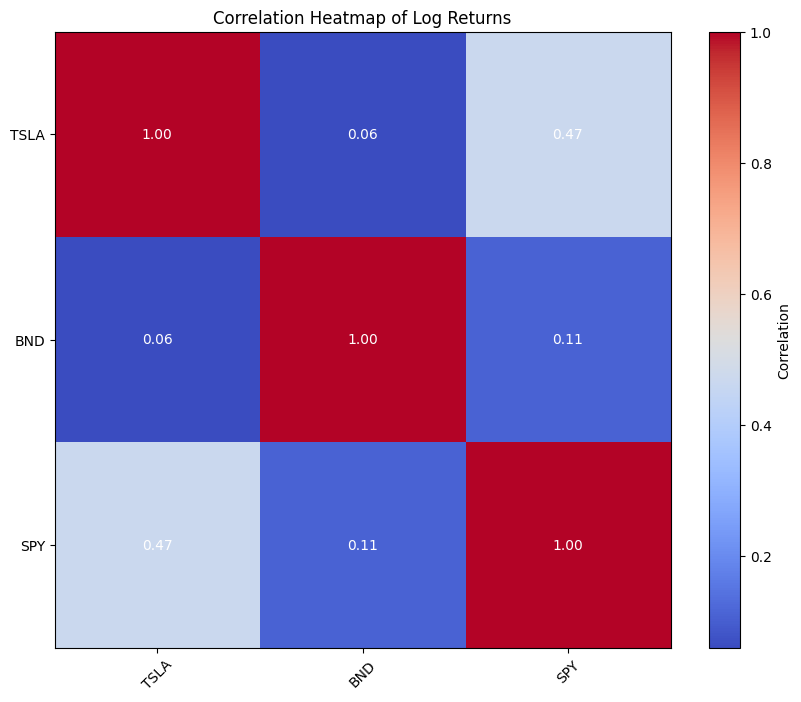

In [18]:
# Plot heatmap with annotations
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Add annotations
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

plt.colorbar(label='Correlation')
plt.title('Correlation Heatmap of Log Returns')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

In [19]:
# Define the number of equities
num_equities = 3

# Calculate equal weights
equal_weights = np.full(num_equities, 1 / num_equities)


# Calculate expected return for each equity
expected_returns = log_returns.mean()

# Calculate portfolio expected return
portfolio_expected_return = np.dot(expected_returns, equal_weights)

print("Portfolio Expected Return:", portfolio_expected_return)


Portfolio Expected Return: 0.0005683878348578397


## Analysis of Portfolio

In [20]:
# Calculate portfolio variance
portfolio_variance = (covariance_matrix.mul(equal_weights, axis=0)
                                      .mul(equal_weights, axis=1)
                                      .sum()
                                      .sum())

print("Portfolio Variance:", portfolio_variance)


Portfolio Variance: 0.00020128642278816565


In [21]:
# Yearly returns for individual companies
yearly_returns = close_prices.resample('Y').last().pct_change()
ind_er = yearly_returns.mean()
ind_er


TSLA    1.000953
BND     0.017341
SPY     0.153997
dtype: float64

In [22]:
# Calculate expected return for each equity
expected_returns = yearly_returns.mean()

# Calculate portfolio expected return
portfolio_expected_return = np.dot(expected_returns, equal_weights)

print("Portfolio Expected Return:", portfolio_expected_return)


Portfolio Expected Return: 0.3907634574421368


In [23]:
# Calculate portfolio variance
portfolio_variance = (covariance_matrix.mul(equal_weights, axis=0)
                                      .mul(equal_weights, axis=1)
                                      .sum()
                                      .sum())

print("Portfolio Variance:", portfolio_variance)


Portfolio Variance: 0.00020128642278816565


In [24]:
# Calculate annualized standard deviation
ann_sd = close_prices.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))

# Combine returns and volatility into a DataFrame
assets = pd.concat([ind_er, ann_sd], axis=1)
assets.columns = ['Returns', 'Volatility']

# Initialize lists for portfolio returns, volatility, and weights
p_ret = []
p_vol = []
p_weights = []

num_assets = len(close_prices.columns)
num_portfolios = 10000

# Generate random portfolios
for _ in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights to sum up to 1
    p_weights.append(weights)
    returns = np.dot(weights, ind_er)  # Portfolio returns
    p_ret.append(returns)
    # Portfolio variance
    var = covariance_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)  # Daily standard deviation
    ann_sd = sd * np.sqrt(250)  # Annual standard deviation = volatility
    p_vol.append(ann_sd)

# Construct DataFrame for portfolios
data = {'Returns': p_ret, 'Volatility': p_vol}
for counter, symbol in enumerate(close_prices.columns.tolist()):
    data[symbol + ' weight'] = [w[counter] for w in p_weights]

portfolios = pd.DataFrame(data)
portfolios.head()


,Returns,Volatility,TSLA weight,BND weight,SPY weight
0,0.354697,0.202169,0.307475,0.436993,0.255532
1,0.382463,0.218289,0.331345,0.381749,0.286907
2,0.647310,0.363996,0.623042,0.251550,0.125408
3,0.136699,0.109130,0.054001,0.461262,0.484737
4,0.310703,0.190710,0.226466,0.256852,0.516682


<Axes: xlabel='Volatility', ylabel='Returns'>

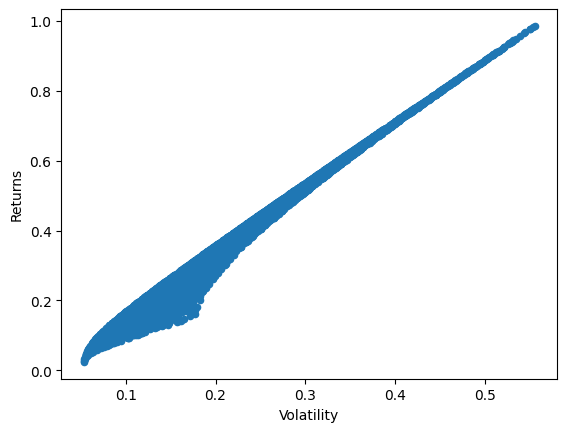

In [25]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', s=20)


In [26]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns        0.028093
Volatility     0.053359
TSLA weight    0.001087
BND weight     0.928054
SPY weight     0.070859
Name: 3069, dtype: float64

In [27]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.848749
Volatility     0.477983
TSLA weight    0.845115
BND weight     0.153842
SPY weight     0.001043
Name: 9898, dtype: float64

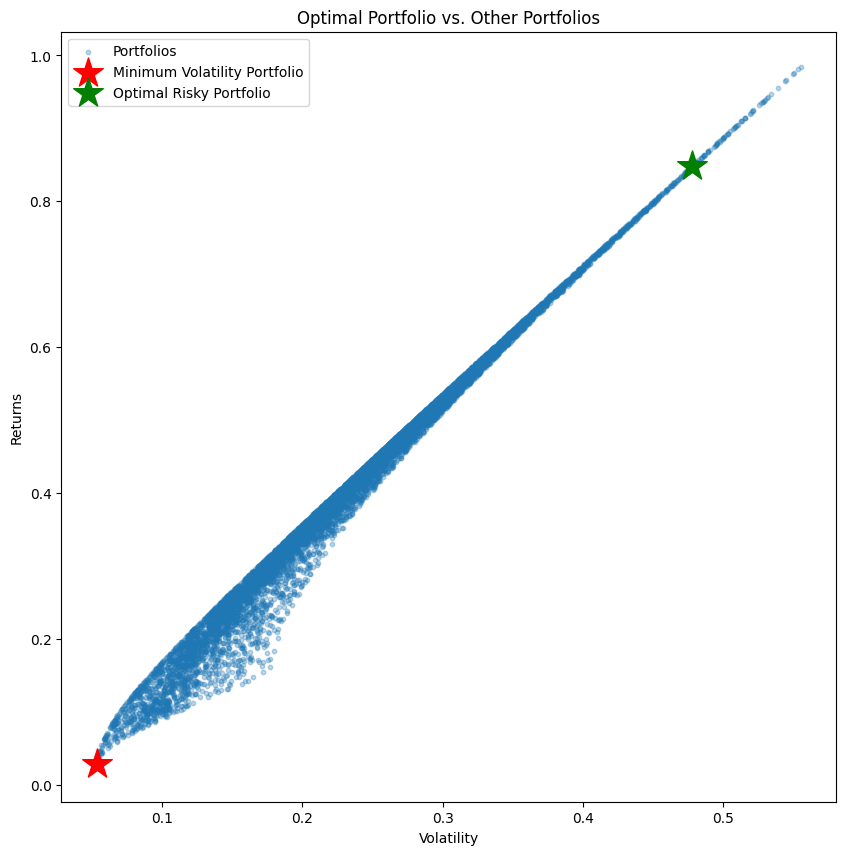

In [28]:
# Plotting the optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'], marker='o', s=10, alpha=0.3, label='Portfolios')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500, label='Minimum Volatility Portfolio')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500, label='Optimal Risky Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Optimal Portfolio vs. Other Portfolios')
plt.legend()
plt.show()


In [29]:
prices = close_prices

# Convert prices to returns
X = prices_to_returns(prices)

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)




In [30]:
X_train.shape , X_test.shape

((1731, 3), (742, 3))

In [31]:
# Create the Mean-Variance model
model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    efficient_frontier_size=30,
    portfolio_params=dict(name="Variance"),
)

# Fit the model on the training set
model.fit(X_train)

# Print the shape of the weights
print(model.weights_.shape)



(30, 3)


In [32]:
# Predict on the training and test sets
population_train = model.predict(X_train)
population_test = model.predict(X_test)

In [33]:
pip install -U nbformat


Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install -U plotly


Note: you may need to restart the kernel to use updated packages.


In [35]:
import nbformat
print(nbformat.__version__)


5.10.4


In [36]:
# Add "Train" and "Test" tags to the portfolios
population_train.set_portfolio_params(tag="Train")
population_test.set_portfolio_params(tag="Test")

# Concatenate the training and test populations
population = population_train + population_test

# Plot measures
fig = population.plot_measures(
    x=RiskMeasure.ANNUALIZED_VARIANCE,
    y=PerfMeasure.ANNUALIZED_MEAN,
    color_scale=RatioMeasure.ANNUALIZED_SHARPE_RATIO,
    hover_measures=[RiskMeasure.MAX_DRAWDOWN, RatioMeasure.ANNUALIZED_SORTINO_RATIO],
)

show(fig)

In [37]:
population_train.plot_composition()

In [38]:
population_test.measures(measure=RatioMeasure.ANNUALIZED_SHARPE_RATIO)

array([-0.17415348, -0.0787511 ,  0.00325412,  0.06571988,  0.11181111,
        0.14469997,  0.16945285,  0.18787807,  0.20203584,  0.21324852,
        0.22226014,  0.22962857,  0.23575357,  0.24099402,  0.24541586,
        0.24911847,  0.25241061,  0.25531171,  0.24100716,  0.22566871,
        0.21173237,  0.19903529,  0.18743592,  0.17681018,  0.1670497 ,
        0.15806001,  0.14975881,  0.1420742 ,  0.13494345,  0.12831136])

In [39]:
population.summary()

,ptf0 - Variance,ptf1 - Variance,ptf2 - Variance,ptf3 - Variance,ptf4 - Variance,ptf5 - Variance,ptf6 - Variance,ptf7 - Variance,ptf8 - Variance,ptf9 - Variance,...,ptf20 - Variance,ptf21 - Variance,ptf22 - Variance,ptf23 - Variance,ptf24 - Variance,ptf25 - Variance,ptf26 - Variance,ptf27 - Variance,ptf28 - Variance,ptf29 - Variance
Mean,0.015%,0.023%,0.031%,0.039%,0.047%,0.055%,0.062%,0.070%,0.078%,0.086%,...,0.035%,0.034%,0.034%,0.033%,0.033%,0.033%,0.032%,0.032%,0.031%,0.031%
Annualized Mean,3.80%,5.79%,7.78%,9.77%,11.75%,13.74%,15.73%,17.71%,19.70%,21.69%,...,8.75%,8.64%,8.54%,8.43%,8.32%,8.22%,8.11%,8.00%,7.90%,7.79%
Variance,0.00081%,0.00096%,0.0014%,0.0021%,0.0030%,0.0042%,0.0057%,0.0074%,0.0094%,0.012%,...,0.068%,0.075%,0.082%,0.090%,0.099%,0.11%,0.12%,0.13%,0.14%,0.15%
Annualized Variance,0.20%,0.24%,0.35%,0.52%,0.76%,1.06%,1.43%,1.87%,2.38%,2.95%,...,17.07%,18.85%,20.74%,22.73%,24.83%,27.03%,29.33%,31.75%,34.26%,36.88%
Semi-Variance,0.00047%,0.00057%,0.00079%,0.0011%,0.0016%,0.0022%,0.0030%,0.0039%,0.0049%,0.0060%,...,0.033%,0.037%,0.040%,0.044%,0.048%,0.052%,0.057%,0.061%,0.066%,0.071%
Annualized Semi-Variance,0.12%,0.14%,0.20%,0.29%,0.41%,0.57%,0.75%,0.98%,1.23%,1.52%,...,8.37%,9.23%,10.13%,11.09%,12.10%,13.15%,14.26%,15.42%,16.63%,17.89%
Standard Deviation,0.28%,0.31%,0.37%,0.45%,0.55%,0.65%,0.75%,0.86%,0.97%,1.08%,...,2.60%,2.74%,2.87%,3.00%,3.14%,3.27%,3.41%,3.55%,3.69%,3.83%
Annualized Standard Deviation,4.52%,4.93%,5.90%,7.21%,8.71%,10.31%,11.98%,13.69%,15.42%,17.17%,...,41.32%,43.42%,45.54%,47.68%,49.83%,51.99%,54.16%,56.34%,58.53%,60.73%
Semi-Deviation,0.22%,0.24%,0.28%,0.34%,0.40%,0.47%,0.55%,0.62%,0.70%,0.78%,...,1.82%,1.91%,2.01%,2.10%,2.19%,2.28%,2.38%,2.47%,2.57%,2.66%
Annualized Semi-Deviation,3.44%,3.78%,4.47%,5.38%,6.41%,7.53%,8.69%,9.88%,11.09%,12.32%,...,28.93%,30.38%,31.83%,33.30%,34.78%,36.27%,37.77%,39.27%,40.78%,42.29%


In [40]:
model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    min_return=np.array([0.15, 0.20, 0.25, 0.30, 0.35]) / 250,
    portfolio_params=dict(name="Variance"),
)

population = model.fit_predict(X_train)

population.plot_measures(
    x=RiskMeasure.ANNUALIZED_VARIANCE,
    y=PerfMeasure.ANNUALIZED_MEAN,
    color_scale=RatioMeasure.ANNUALIZED_SHARPE_RATIO,
    hover_measures=[RiskMeasure.MAX_DRAWDOWN, RatioMeasure.ANNUALIZED_SORTINO_RATIO],
)
